<b>NOTES FOR THE VIEWER AS OF 3:47 AM NOV 26</b>

<blockquote> 
    
    1. Need to explore more features, possibly within csv file or from outside sources like gdp or 3rd world country tagging etc.
    2. 11.8K average MAE as of now
    3. Tried imputing values based on median or mode depending on dtype of feature
    4. Tried isolation forest as suggested by basti, not sure how to tune it tho, just used arbitrary params.
</blockquote> 

# Imports

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm
from sklearn.impute import SimpleImputer
%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm_notebook
from collections import Counter

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re

# Loading Data

In [70]:
df_raw = pd.read_csv('survey_results_public.csv')
df_raw

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physic...,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Neither easy nor difficult,816816.0


In [71]:
df_raw.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'US_State',
       'UK_Country', 'EdLevel', 'Age1stCode', 'LearnCode', 'YearsCode',
       'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal',
       'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys',
       'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq',
       'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
       'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')

# Cleaning

## Dropping Unimportant Columns

In [72]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase']
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop.head(3)

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,"Secondary school (e.g. American high school, G...",NaN,NaN,"Developer, mobile",20 to 99 employees,C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift,PostgreSQL;SQLite,NaN,MacOS,A few times per month or weekly,25-34 years old,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,NaN,NaN,NaN,JavaScript;Python,PostgreSQL,NaN,Windows,Daily or almost daily,18-24 years old,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,NaN,NaN,NaN,Assembly;C;Python;R;Rust,SQLite,Heroku,MacOS,Multiple times per day,18-24 years old,NaN


In [73]:
df_drop.dtypes

ResponseId                  int64
MainBranch                 object
Employment                 object
Country                    object
EdLevel                    object
YearsCode                  object
YearsCodePro               object
DevType                    object
OrgSize                    object
LanguageHaveWorkedWith     object
DatabaseHaveWorkedWith     object
PlatformHaveWorkedWith     object
OpSys                      object
SOPartFreq                 object
Age                        object
ConvertedCompYearly       float64
dtype: object

In [74]:
df_drop.isna().sum()

ResponseId                    0
MainBranch                    0
Employment                  116
Country                       0
EdLevel                     313
YearsCode                  1798
YearsCodePro              22223
DevType                   16955
OrgSize                   22713
LanguageHaveWorkedWith     1082
DatabaseHaveWorkedWith    13893
PlatformHaveWorkedWith    31304
OpSys                       145
SOPartFreq                15886
Age                        1032
ConvertedCompYearly       36595
dtype: int64

In [75]:
df_drop.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'OpSys', 'SOPartFreq', 'Age',
       'ConvertedCompYearly'],
      dtype='object')

In [76]:
df_drop = df_drop.dropna(subset=['ConvertedCompYearly', 'DevType', 'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith'])
display(df_drop.shape)
df_drop.isna().sum()

(30667, 16)

ResponseId                   0
MainBranch                   0
Employment                   0
Country                      0
EdLevel                     12
YearsCode                  227
YearsCodePro               271
DevType                      0
OrgSize                     28
LanguageHaveWorkedWith       0
DatabaseHaveWorkedWith       0
PlatformHaveWorkedWith       0
OpSys                        6
SOPartFreq                4491
Age                         73
ConvertedCompYearly          0
dtype: int64

# Imputing

In [77]:
# imputer_median = SimpleImputer()

def years_code_mapping(x):
    if x == 'Less than 1 year':
        return 0.5
    elif x == 'More than 50 years':
        return 55
    elif x is np.nan:
        return x
    else:
        return int(x)
    
df_drop['YearsCode'] = df_drop['YearsCode'].apply(years_code_mapping)
df_drop['YearsCodePro'] = df_drop['YearsCodePro'].apply(years_code_mapping)

df_drop['YearsCode']  = df_drop['YearsCode'].replace(np.nan, df_drop['YearsCode'].median())
df_drop['YearsCodePro']  = df_drop['YearsCodePro'].replace(np.nan, df_drop['YearsCodePro'].median())

In [78]:
# def mode_imputer(x):
df_drop['EdLevel'] = df_drop['EdLevel'].copy().apply(lambda x: df_drop['EdLevel'].mode().values[0] if x is np.nan else x)
df_drop['Employment'] = df_drop['Employment'].copy().apply(lambda x: df_drop['Employment'].mode().values[0] if x is np.nan else x)
df_drop['OrgSize'] = df_drop['OrgSize'].copy().apply(lambda x: df_drop['OrgSize'].mode().values[0] if x is np.nan else x)
df_drop['SOPartFreq'] = df_drop['SOPartFreq'].copy().apply(lambda x: df_drop['SOPartFreq'].mode().values[0] if x is np.nan else x)
df_drop['Age'] = df_drop['Age'].copy().apply(lambda x: df_drop['Age'].mode().values[0] if x is np.nan else x)
df_drop['OpSys'] = df_drop['OpSys'].copy().apply(lambda x: df_drop['OpSys'].mode().values[0] if x is np.nan else x)


# df_drop[df_drop['EdLevel'].isna()]

In [79]:
df_drop['EdLevel'].mode().values[0]

'Bachelor’s degree (B.A., B.S., B.Eng., etc.)'

In [80]:
df_drop.isna().sum()

ResponseId                0
MainBranch                0
Employment                0
Country                   0
EdLevel                   0
YearsCode                 0
YearsCodePro              0
DevType                   0
OrgSize                   0
LanguageHaveWorkedWith    0
DatabaseHaveWorkedWith    0
PlatformHaveWorkedWith    0
OpSys                     0
SOPartFreq                0
Age                       0
ConvertedCompYearly       0
dtype: int64

In [81]:
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
11,12,I am a developer by profession,Employed full-time,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12.0,5.0,"Developer, back-end",10 to 19 employees,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,PostgreSQL,AWS,Linux-based,Less than once per month or monthly,25-34 years old,46482.0
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.0,2.0,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
17,18,I am a developer by profession,Employed full-time,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9.0,6.0,"Developer, front-end;Developer, full-stack;Dev...",500 to 999 employees,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL,MySQL;PostgreSQL,AWS,MacOS,Multiple times per day,25-34 years old,46135.0
24,25,I am a developer by profession,Employed full-time,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",26.0,18.0,"Developer, front-end;Developer, desktop or ent...","1,000 to 4,999 employees",C++;HTML/CSS;Java;JavaScript;Kotlin;Node.js;Ty...,DynamoDB;PostgreSQL,AWS;Heroku,Linux-based,A few times per week,35-44 years old,77831.0
31,32,I am a developer by profession,Employed full-time,Israel,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4.0,2.0,"Engineer, data;Developer, back-end","5,000 to 9,999 employees",Bash/Shell;Go;Java;Node.js;Python;Scala;SQL,DynamoDB;MongoDB;MySQL;PostgreSQL,AWS;Google Cloud Platform;Microsoft Azure,MacOS,A few times per month or weekly,25-34 years old,122580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83432,83433,I am a developer by profession,Employed full-time,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5.0,0.5,"Developer, back-end","10,000 or more employees",Ruby,MySQL;PostgreSQL,Google Cloud Platform;Heroku,MacOS,Less than once per month or monthly,18-24 years old,80169.0
83434,83435,I am a developer by profession,Employed full-time,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.0,5.0,"Developer, back-end",20 to 99 employees,Clojure;Kotlin;SQL,Oracle;SQLite,AWS,MacOS,Less than once per month or monthly,25-34 years old,160500.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,"Secondary school (e.g. American high school, G...",10.0,4.0,Data scientist or machine learning specialist;...,"10,000 or more employees",Groovy;Java;Python,DynamoDB;Elasticsearch;MongoDB;PostgreSQL;Redis,AWS;Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5.0,3.0,"Developer, back-end",20 to 99 employees,Bash/Shell;JavaScript;Node.js;Python,Cassandra;Elasticsearch;MongoDB;PostgreSQL;Redis,Heroku,MacOS,Less than once per month or monthly,25-34 years old,816816.0


## Dropping Asian Countries

In [82]:

df_drop.Country.unique()


asian_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 'Sri Lanka',
                   'Georgia', 'Hong Kong (S.A.R.)', 'Japan', 'United Arab Emirates', 
                   'Turkey', 'Pakistan', 'Lebanon', 'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
                   'Syrian Arab Republic', 'Taiwan', 'South Korea', 'Viet Nam', 
                   "Lao People's Democratic Republic", 'Nepal', 'Philippines', 'Azerbaijan', 
                   'Saudi Arabia', 'Singapore', 'Armenia', 'Cyprus', 'Kuwait', 'Thailand', 
                   'Myanmar', 'Kazakhstan', 'Iraq', 'Bahrain', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 
                   'Republic of Korea', 'Tajikistan', 'Oman', 'Palestine', 'Afghanistan', 'Mongolia', 'Maldives',
                   'Qatar', 'Turkmenistan'
                  ]

df_drop = df_drop[df_drop['Country'].isin(asian_countries)]
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.0,2.0,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5.0,3.0,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2.0,2.0,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20.0,7.0,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4.0,2.0,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83355,83356,I am a developer by profession,Employed full-time,Japan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8.0,3.0,"Developer, front-end;Developer, desktop or ent...",20 to 99 employees,C#;HTML/CSS;JavaScript;SQL;TypeScript,Microsoft SQL Server,AWS,Windows,Less than once per month or monthly,35-44 years old,450.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11.0,5.0,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0
83402,83403,I am a developer by profession,Employed full-time,South Korea,"Secondary school (e.g. American high school, G...",4.0,0.5,"Developer, mobile;Developer, front-end;Develop...",2 to 9 employees,C;Dart;HTML/CSS;Java;JavaScript;Kotlin;Node.js,Firebase;MariaDB;MongoDB;MySQL;Oracle,AWS;Heroku,MacOS,I have never participated in Q&A on Stack Over...,18-24 years old,18708.0
83411,83412,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8.0,5.0,"Developer, back-end",100 to 499 employees,Java;JavaScript;SQL,MySQL,AWS,MacOS,Less than once per month or monthly,25-34 years old,48866.0


In [83]:
data_dev_list = ['Data scientist or machine learning specialist', 'Database administrator', 'Data or business analyst', 'Engineer, data']
ser_dev = df_drop['DevType'].str.split(';')
index_list = []
for idx, elem in ser_dev.iteritems():
    for item in elem:
        if item in data_dev_list:
            index_list.append(idx)
            break
df_devs = df_drop.loc[index_list,:]
df_devs

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5.0,3.0,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2.0,2.0,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20.0,7.0,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4.0,2.0,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
213,214,I am a developer by profession,Employed full-time,Russian Federation,"Other doctoral degree (Ph.D., Ed.D., etc.)",15.0,9.0,"Developer, mobile;Developer, full-stack;Data s...","10,000 or more employees",C#;Java;Python,PostgreSQL,Google Cloud Platform,Windows,A few times per month or weekly,25-34 years old,75492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,"I am not primarily a developer, but I write co...",Employed full-time,India,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14.0,11.0,"Developer, front-end;Developer, full-stack;Dev...",20 to 99 employees,Bash/Shell;Go;HTML/CSS;PHP;SQL,Elasticsearch;MariaDB;Redis;SQLite,AWS;DigitalOcean,MacOS,Daily or almost daily,25-34 years old,13962.0
83291,83292,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5.0,2.0,"Engineer, data;Data or business analyst;Engine...","10,000 or more employees",C;HTML/CSS;Java;PowerShell;Python;SQL,Microsoft SQL Server;MySQL;Oracle;SQLite,Google Cloud Platform,Windows,A few times per week,18-24 years old,5026.0
83294,83295,I am a developer by profession,Employed full-time,Russian Federation,Some college/university study without earning ...,15.0,13.0,"Developer, back-end;Database administrator;Dev...",20 to 99 employees,Node.js;PHP,MariaDB;MySQL;PostgreSQL;SQLite,Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,30192.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11.0,5.0,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0


In [84]:
# OHE_list = []
# ordinal_list = []
# for col in df_asia.columns:
#     print(col, '\n--------------')
#     display(df_asia[col].unique())
#     ans = input('action')
#     if ans == 'cat':
#         OHE_list.append(col)
#     elif ans == 'ord':
#         ordinal_list.append(col)

In [85]:
OHE_list = ['Employment', 'Country', 'OpSys', 'Age']

In [86]:
ordinal_list = ['MainBranch', 'EdLevel', 'OrgSize', 'SOPartFreq']

**Columns that need transformation**

In [87]:
df_devs[df_devs.columns.difference(OHE_list+ordinal_list)].head()

,ConvertedCompYearly,DatabaseHaveWorkedWith,DevType,LanguageHaveWorkedWith,PlatformHaveWorkedWith,ResponseId,YearsCode,YearsCodePro
58,22644.0,Oracle,"Developer, full-stack;Data scientist or machin...",Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Heroku,59,5.0,3.0
148,36000.0,SQLite,Database administrator;Data or business analyst,SQL,Google Cloud Platform,149,2.0,2.0
154,2340.0,Firebase;MariaDB;MongoDB;MySQL;Redis,"Developer, front-end;Developer, full-stack;Dev...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Heroku,155,20.0,7.0
168,14844.0,SQLite,"Developer, front-end;Engineer, data;Developer,...",HTML/CSS;JavaScript;Python;SQL,DigitalOcean;Heroku,169,4.0,2.0
213,75492.0,PostgreSQL,"Developer, mobile;Developer, full-stack;Data s...",C#;Java;Python,Google Cloud Platform,214,15.0,9.0


## Prepping Features with top X filtering

In [88]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_devs[col_name].str.split(';'):
         li = li + row

    df_try = df_devs[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [89]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 12, 'Lang')
lang_OHE

,Lang_SQL,Lang_Python,Lang_JavaScript,Lang_HTML/CSS,Lang_Node.js,Lang_Java,Lang_PHP,Lang_C#,Lang_C++,Lang_TypeScript,Lang_Bash/Shell,Lang_C
index,,,,,,,,,,,,
58,1,1,1,1,0,0,0,0,0,0,1,0
148,1,0,0,0,0,0,0,0,0,0,0,0
154,1,1,1,1,1,0,1,0,0,0,0,0
168,1,1,1,1,0,0,0,0,0,0,0,0
213,0,1,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,1,0,0,1,0,0,0,1,0
83291,1,1,0,1,0,1,0,0,0,0,0,1
83294,0,0,0,0,1,0,1,0,0,0,0,0


In [90]:
devtype_OHE = OHE_semicolon_vals('DevType', 10, 'Dev')
devtype_OHE

,"Dev_Developer, back-end","Dev_Developer, full-stack",Dev_Database administrator,"Dev_Engineer, data",Dev_Data scientist or machine learning specialist,"Dev_Developer, front-end",Dev_Data or business analyst,Dev_System administrator,"Dev_Developer, desktop or enterprise applications","Dev_Developer, mobile"
index,,,,,,,,,,
58,0,1,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,1,0,0,0
154,1,1,1,0,0,1,0,1,0,0
168,1,0,0,1,0,1,0,0,0,0
213,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
83046,1,1,1,0,0,1,0,1,0,0
83291,0,0,0,1,0,0,1,0,0,0
83294,1,0,1,0,0,0,0,0,0,0


In [91]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 10, 'DB')
database_OHE

,DB_MySQL,DB_PostgreSQL,DB_MongoDB,DB_SQLite,DB_Microsoft SQL Server,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle
index,,,,,,,,,,
58,0,0,0,0,0,0,0,0,0,1
148,0,0,0,1,0,0,0,0,0,0
154,1,0,1,0,0,1,1,1,0,0
168,0,0,0,1,0,0,0,0,0,0
213,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
83046,0,0,0,1,0,1,1,0,1,0
83291,1,0,0,1,1,0,0,0,0,1
83294,1,1,0,1,0,0,1,0,0,0


In [92]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 10, 'Plat')
platform_OHE

,Plat_AWS,Plat_Google Cloud Platform,Plat_Microsoft Azure,Plat_DigitalOcean,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,
58,0,0,0,0,1,0,0
148,0,1,0,0,0,0,0
154,0,0,0,0,1,0,0
168,0,0,0,1,1,0,0
213,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
83046,1,0,0,1,0,0,0
83291,0,1,0,0,0,0,0
83294,0,1,0,0,0,0,0


Changing `YearsCode` and `YearsCodeProd` to numeric

In [93]:
df_devs['YearsCode']

58        5.0
148       2.0
154      20.0
168       4.0
213      15.0
         ... 
83046    14.0
83291     5.0
83294    15.0
83356    11.0
83431     9.0
Name: YearsCode, Length: 1089, dtype: float64

In [94]:
#YearsCode
# def years_code_mapping(x):
#     if x == 'Less than 1 year':
#         return 0.5
#     elif x == 'More than 50 years':
#         return 55
#     elif x == np.nan:
#         return x
#     else:
#         return int(x)

# df_devs['YearsCode'] = df_devs['YearsCode'].copy().apply(years_code_mapping)
# #YearsCodePro
# df_devs['YearsCodePro'] = df_devs['YearsCodePro'].copy().apply(years_code_mapping)


## Ordinal Mapping 

In [95]:
df_devs['MainBranch'].unique()

array(['I am not primarily a developer, but I write code sometimes as part of my work',
       'I am a developer by profession'], dtype=object)

In [96]:

MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_devs['MainBranch'] = df_devs['MainBranch'].copy().map(MainBranch_mapping)

In [97]:
# len(df_devs['EdLevel'].unique())

In [98]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_devs['EdLevel'] = df_devs['EdLevel'].copy().map(EdLevel_mapping)
# df_asia
# df_asia['EdLevel']

In [99]:
len(df_devs['OrgSize'].unique())

10

In [100]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_devs['OrgSize'] = df_devs['OrgSize'].copy().map(OrgSize_mapping)

In [101]:
len(df_devs['SOPartFreq'].unique())

6

In [102]:
df_devs['SOPartFreq'].unique()

SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_devs['SOPartFreq'] = df_devs['SOPartFreq'].copy().map(SOPartFreq_mapping)

In [103]:
df_devs[ordinal_list]

,MainBranch,EdLevel,OrgSize,SOPartFreq
58,0,8,4,1
148,0,6,1,5
154,1,5,1,4
168,1,3,1,4
213,1,7,9,2
...,...,...,...,...
83046,0,6,4,4
83291,1,5,9,3
83294,1,3,4,0
83356,1,5,1,0


## OHE

In [104]:
df_devs[OHE_list]

,Employment,Country,OpSys,Age
58,Employed full-time,Russian Federation,Linux-based,25-34 years old
148,"Independent contractor, freelancer, or self-em...",Sri Lanka,Windows,25-34 years old
154,"Independent contractor, freelancer, or self-em...",India,Windows,25-34 years old
168,"Independent contractor, freelancer, or self-em...",Georgia,Linux-based,18-24 years old
213,Employed full-time,Russian Federation,Windows,25-34 years old
...,...,...,...,...
83046,Employed full-time,India,MacOS,25-34 years old
83291,Employed full-time,India,Windows,18-24 years old
83294,Employed full-time,Russian Federation,Windows,25-34 years old
83356,"Independent contractor, freelancer, or self-em...",Indonesia,Windows Subsystem for Linux (WSL),25-34 years old


In [105]:
df_devs['ConvertedCompYearly'] = df_devs['ConvertedCompYearly'].astype(int)
numeric_data = df_devs.select_dtypes(['int', 'float'])
numeric_data.index.name='index'
numeric_data

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly
index,,,,,,,,
58,59,0,8,5.0,3.0,4,1,22644
148,149,0,6,2.0,2.0,1,5,36000
154,155,1,5,20.0,7.0,1,4,2340
168,169,1,3,4.0,2.0,1,4,14844
213,214,1,7,15.0,9.0,9,2,75492
...,...,...,...,...,...,...,...,...
83046,83047,0,6,14.0,11.0,4,4,13962
83291,83292,1,5,5.0,2.0,9,3,5026
83294,83295,1,3,15.0,13.0,4,0,30192


In [106]:
OHE_data = pd.concat([lang_OHE,database_OHE, devtype_OHE, platform_OHE, pd.get_dummies(df_devs[OHE_list])], axis=1)
df_final = pd.merge(left=numeric_data, right=OHE_data, left_index=True, right_index=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_Python,...,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL),Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,5.0,3.0,4,1,22644,1,1,...,0,0,0,0,1,0,0,0,0,0
148,149,0,6,2.0,2.0,1,5,36000,1,0,...,0,1,0,0,1,0,0,0,0,0
154,155,1,5,20.0,7.0,1,4,2340,1,1,...,0,1,0,0,1,0,0,0,0,0
168,169,1,3,4.0,2.0,1,4,14844,1,1,...,0,0,0,1,0,0,0,0,0,0
213,214,1,7,15.0,9.0,9,2,75492,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,14.0,11.0,4,4,13962,1,0,...,0,0,0,0,1,0,0,0,0,0
83291,83292,1,5,5.0,2.0,9,3,5026,1,1,...,0,1,0,1,0,0,0,0,0,0
83294,83295,1,3,15.0,13.0,4,0,30192,0,0,...,0,1,0,0,1,0,0,0,0,0


# EDA

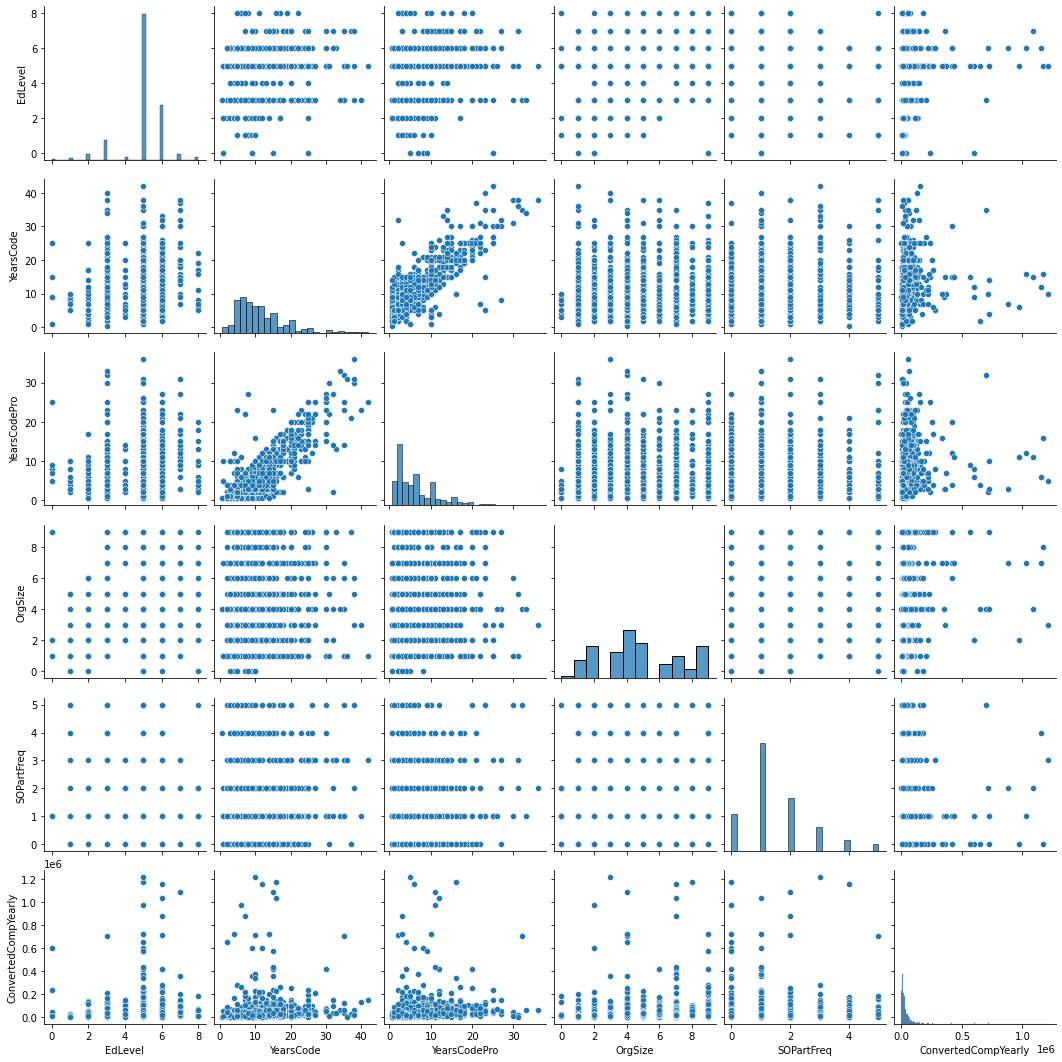

In [107]:
sns.pairplot(data=df_final[['EdLevel', 'YearsCode', 'YearsCodePro', 'OrgSize', 'SOPartFreq', 'ConvertedCompYearly']], diag_kind='hist')
plt.show()

Skewed features may need log transformation to improve model results. idk yet will initially try running models on not transformed data

In [108]:
df_final['YearsCodePro'].describe()

count    1089.000000
mean        6.708907
std         5.547068
min         0.500000
25%         3.000000
50%         5.000000
75%        10.000000
max        36.000000
Name: YearsCodePro, dtype: float64

<AxesSubplot:ylabel='Frequency'>

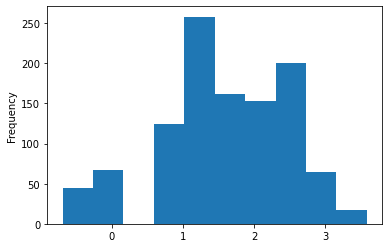

In [109]:
df_final['YearsCodePro'] = df_final['YearsCodePro'].copy().apply(np.log)
df_final['YearsCodePro'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

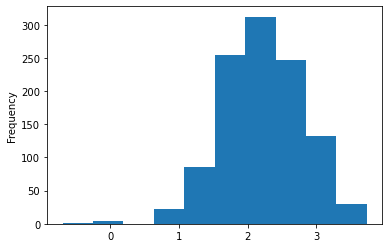

In [110]:
df_final['YearsCode'] = df_final['YearsCode'].copy().apply(np.log)
df_final['YearsCode'].plot(kind='hist')

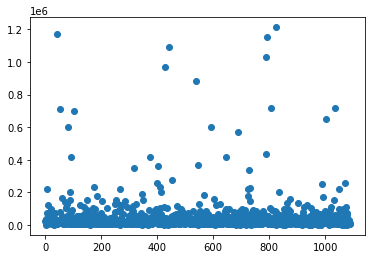

In [111]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

C:\Users\JG\AppData\Local\Temp/ipykernel_21276/129434316.py:8: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



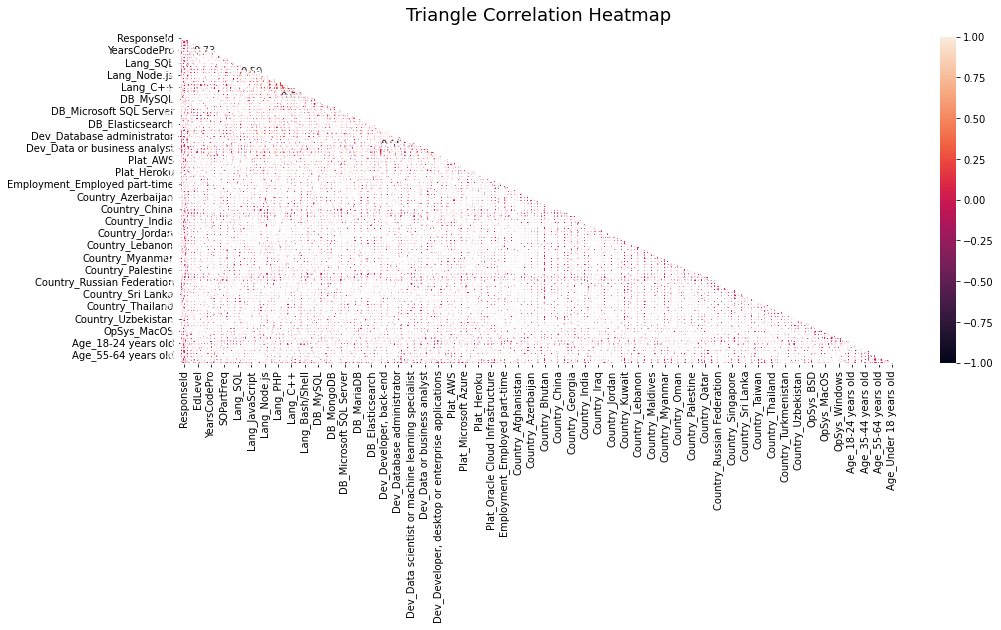

In [112]:
# code snippet for triangle correlation heatmap

def get_tri_corr_matrix(df_eda, figsize):
    
    plt.figure(figsize=figsize)
    # define the mask to set the values in the upper triangle to True

    mask = np.triu(np.ones_like(df_eda.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df_eda.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

get_tri_corr_matrix(df_final, (16,6))

<AxesSubplot:>

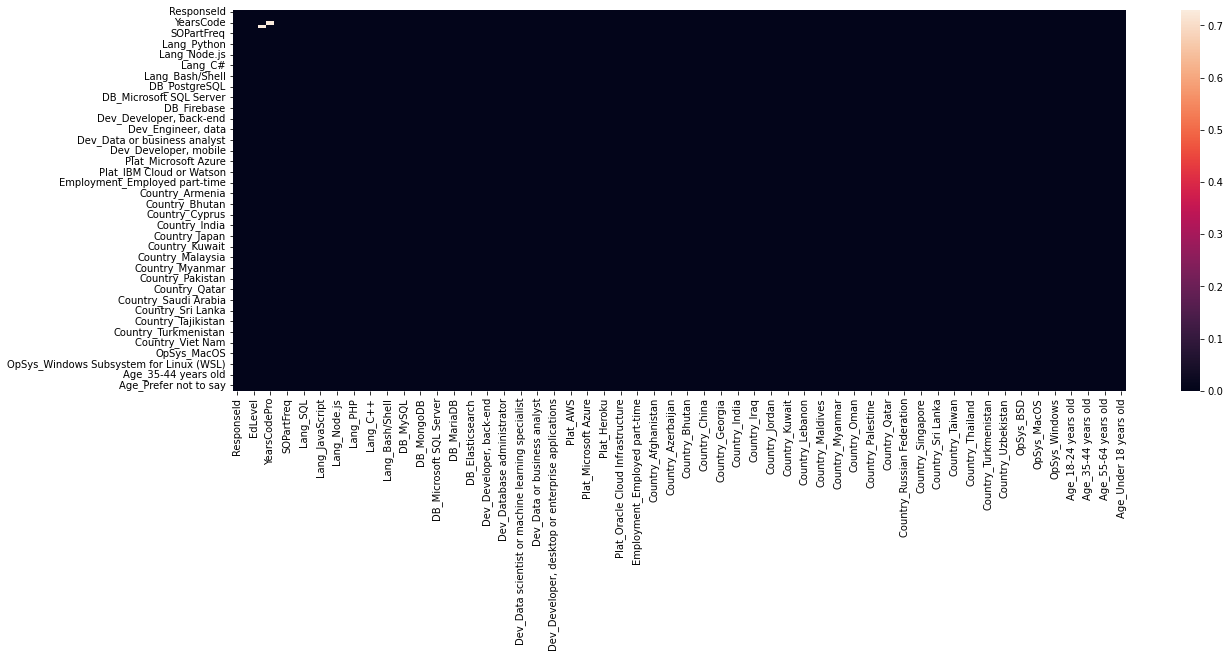

In [113]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(df_final.corr().applymap(lambda x: x if (x>=0.65) and (x!=1.0) else 0))

In [114]:
corr = df_final.corr().applymap(lambda x: x if (x>=0.60) and (x!=1.0) else np.nan)
i=0
for col in corr.columns:
    
    filtered = corr[[col]].dropna()
    if len(filtered)>0:
        print(col, filtered.index.tolist(), '\n------')
        display(filtered.sum().values)
    # if filtered.sum().values > 0:
    #     display(filtered)

YearsCode ['YearsCodePro'] 
------


array([0.72890307])

YearsCodePro ['YearsCode'] 
------


array([0.72890307])

Lang_C++ ['Lang_C'] 
------


array([0.61893562])

Lang_C ['Lang_C++'] 
------


array([0.61893562])

In [115]:
corr[['YearsCode']]

,YearsCode
ResponseId,NaN
MainBranch,NaN
EdLevel,NaN
YearsCode,NaN
YearsCodePro,0.728903
...,...
Age_35-44 years old,NaN
Age_45-54 years old,NaN
Age_55-64 years old,NaN
Age_Prefer not to say,NaN


## Removing Outliers

### Manual Outlier detection (OFF if isoforest is ON)

In [116]:
# idx_outliers_y = df_final['ConvertedCompYearly'].sort_values(ascending=False).head(10).index.to_list()
# display(df_drop.loc[idx_outliers_y,:])
# df_final = df_final.drop(idx_outliers_y, axis=0)
# df_final

## Testing isolation forest for outlier detection

In [117]:
from sklearn.ensemble import IsolationForest
isoforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.15 , max_features=1, random_state=11)
isoforest.fit(df_final[['ConvertedCompYearly']])

df_final['scores']=isoforest.decision_function(df_final[['ConvertedCompYearly']])
df_final['anomaly']=isoforest.predict(df_final[['ConvertedCompYearly']])

C:\Users\JG\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [118]:
outliers_iso = df_final[df_final['anomaly']==-1].index
print('number of outliers: ', len(outliers_iso), '\n shape of df_final with outliers: ', df_final.shape)
df_final.drop(outliers_iso, axis=0, inplace=True)

number of outliers:  164 
 shape of df_final with outliers:  (1089, 109)


In [119]:
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_Python,...,OpSys_Windows Subsystem for Linux (WSL),Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,1.609438,1.098612,4,1,22644,1,1,...,0,0,1,0,0,0,0,0,0.084072,1
148,149,0,6,0.693147,0.693147,1,5,36000,1,0,...,0,0,1,0,0,0,0,0,0.053897,1
154,155,1,5,2.995732,1.945910,1,4,2340,1,1,...,0,0,1,0,0,0,0,0,0.005019,1
168,169,1,3,1.386294,0.693147,1,4,14844,1,1,...,0,1,0,0,0,0,0,0,0.086267,1
554,555,1,5,1.098612,0.000000,1,3,11724,1,0,...,0,1,0,0,0,0,0,0,0.099887,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,2.639057,2.397895,4,4,13962,1,0,...,0,0,1,0,0,0,0,0,0.090654,1
83291,83292,1,5,1.609438,0.693147,9,3,5026,1,1,...,0,1,0,0,0,0,0,0,0.082288,1
83294,83295,1,3,2.708050,2.564949,4,0,30192,0,0,...,0,0,1,0,0,0,0,0,0.074435,1


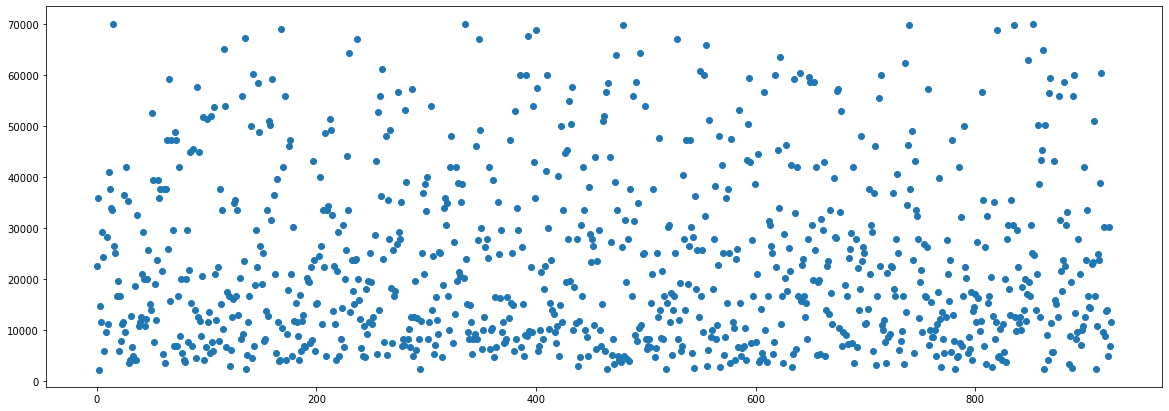

In [120]:
fig, ax = plt.subplots(figsize=(20,7))
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

## Adding/Removing features

In [121]:
def filter_lang(prefix):
    li = []
    for elem in df_final.columns:
        if prefix in elem:
            li.append(elem)
    return li

lang_cols = filter_lang('Lang_')
df_final['LCount'] = df_final[lang_cols].sum(axis=1)

dev_cols = filter_lang('Dev_')
df_final['DCount'] = df_final[dev_cols].sum(axis=1)

plat_cols = filter_lang('Plat_')
df_final['PCount'] = df_final[plat_cols].sum(axis=1)

db_cols = filter_lang('DB_')
df_final['DbCount'] = df_final[db_cols].sum(axis=1)


country_cols = filter_lang('Country_')
# country_cols = []

# removing language, devs, plat, db, country cols
# df_final = df_final.drop(
#     lang_cols+dev_cols+plat_cols+db_cols+country_cols, axis=1
# )


# removing platforms, database, country features only
# df_final = df_final.drop(
#     plat_cols+db_cols+country_cols, axis=1
# )

# removing platforms, database features only #best so far 3:41 am nov 26
df_final = df_final.drop(
    plat_cols+db_cols, axis=1
)


df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Lang_SQL,Lang_Python,...,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,1.609438,1.098612,4,1,22644,1,1,...,0,0,0,0,0.084072,1,5,2,1,1
148,149,0,6,0.693147,0.693147,1,5,36000,1,0,...,0,0,0,0,0.053897,1,1,2,1,1
154,155,1,5,2.995732,1.945910,1,4,2340,1,1,...,0,0,0,0,0.005019,1,6,5,1,5
168,169,1,3,1.386294,0.693147,1,4,14844,1,1,...,0,0,0,0,0.086267,1,4,3,2,1
554,555,1,5,1.098612,0.000000,1,3,11724,1,0,...,0,0,0,0,0.099887,1,8,6,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,2.639057,2.397895,4,4,13962,1,0,...,0,0,0,0,0.090654,1,4,5,2,4
83291,83292,1,5,1.609438,0.693147,9,3,5026,1,1,...,0,0,0,0,0.082288,1,5,2,1,4
83294,83295,1,3,2.708050,2.564949,4,0,30192,0,0,...,0,0,0,0,0.074435,1,2,2,1,4


# ML

In [122]:
X = df_final[df_final.columns.difference(['ConvertedCompYearly', 'ResponseId', 'scores', 'anomaly'])]
y = df_final['ConvertedCompYearly']

In [123]:

y.sort_values(ascending=False)

index
30938    70044
1194     70000
75977    70000
74588    69828
67283    69809
         ...  
12695     2508
40846     2465
44991     2400
76801     2388
154       2340
Name: ConvertedCompYearly, Length: 925, dtype: int32

## Logged y

since y is initially skewed

In [124]:

y = np.log(y)
y

index
58       10.027650
148      10.491274
154       7.757906
168       9.605351
554       9.369393
           ...    
83046     9.544095
83291     8.522380
83294    10.315332
83356     8.856518
83431     9.365291
Name: ConvertedCompYearly, Length: 925, dtype: float64

## Train-Test Split

In [125]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25)

## CV

In [126]:
# from sklearn.ensemble import RandomForestRegressor

# rf_test = RandomForestRegressor()
# rf_test.fit(X_trainval, y_trainval)
# rf_test_pred = rf_test.predict(X_holdout)
# mean_absolute_error(y_holdout, rf_test_pred)

### RF

In [127]:
def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import KFold
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1])
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features)
        scaler = MinMaxScaler()
        
        rf_pipe = Pipeline(steps = [['scale', scaler],['rf', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        kf = KFold(n_splits=5)
        mae_list=[]
        for train_idx, val_idx in kf.split(X):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
            
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_val)
            mae = mean_absolute_error(np.exp(y_val), np.exp(y_pred))
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=70, n_jobs=4)
    return study, optimize

In [128]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-11-26 19:32:06,711] A new study created in memory with name: no-name-c5676151-7a4a-4805-99c2-437798c634cf
C:\Users\JG\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2021-11-26 19:32:12,533] Trial 1 finished with value: 10321.199877936586 and parameters: {'n_estimators': 210, 'max_depth': 54, 'max_features': 42}. Best is trial 1 with value: 10321.199877936586.
[I 2021-11-26 19:32:13,020] Trial 2 finished with value: 10706.450028300596 and parameters: {'n_estimators': 310, 'max_depth': 5, 'max_features': 91}. Best is trial 1 with value: 10321.199877936586.
[I 2021-11-26 19:32:14,695] Trial 0 finished with value: 10389.175340566158 and parameters: {'n_estimators': 210, 'max_depth': 77, 'max_features': 80}. Best is trial 1 with value: 10321.199877936586.
[I 2021-11-26 19:32:19,069] Trial 5 finished with value:

In [129]:
rf_study.best_params

{'n_estimators': 200, 'max_depth': 51, 'max_features': 45}

In [130]:
rf_study.best_value

10311.17337949379

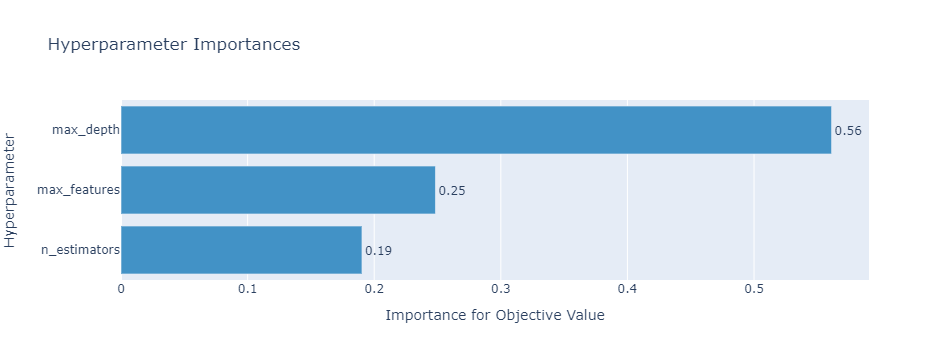

In [131]:
fig = optuna.visualization.plot_param_importances(rf_study)
fig.show()

### Testing Optimal RF

In [132]:
rf = RandomForestRegressor(**rf_study.best_params, random_state=11)


n_trials = 20
mae_list = []
for n in tqdm_notebook(range(n_trials)):

    (X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                                          random_state=n, 
                                                          test_size=0.25)
    scaler = MinMaxScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)

    mae = mean_absolute_error(np.exp(y_test), np.exp(rf_pred)) # on 
    mae_list.append(mae)
np.mean(mae_list)
# mean_absolute_error(np.exp(y_holdout), np.exp(rf_pred))
# without outliers using isoforest (world)
# 23858 using 0.12 contamination

# without outliers using isoforest (Asia)
# 11k using 0.12 contamination
# 11937.776566711611 including devtype



#######
# median_absolute_error(np.exp(y_holdout), np.exp(rf_pred))

  0%|          | 0/20 [00:00<?, ?it/s]

10792.095860289553

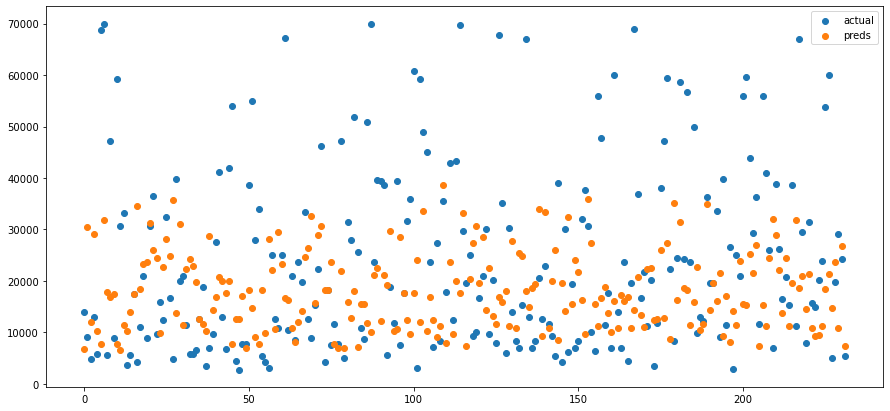

In [133]:
y_holdout_plot = y_holdout.reset_index().drop(columns='index', axis=0)


fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(y_holdout_plot.index, np.exp(y_holdout_plot), label='actual')
plt.scatter(y_holdout_plot.index, np.exp(rf_pred), label='preds')
plt.legend()
# plt.ylim(0, 400000)

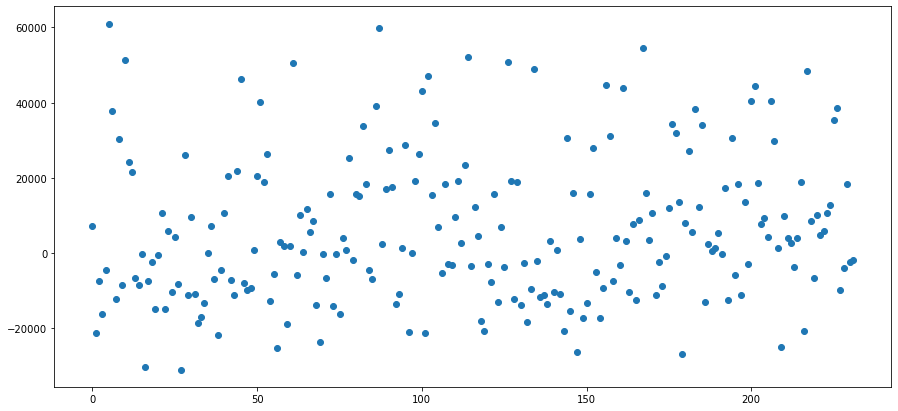

In [134]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(range(len(rf_pred)), np.exp(y_holdout) - np.exp(rf_pred))

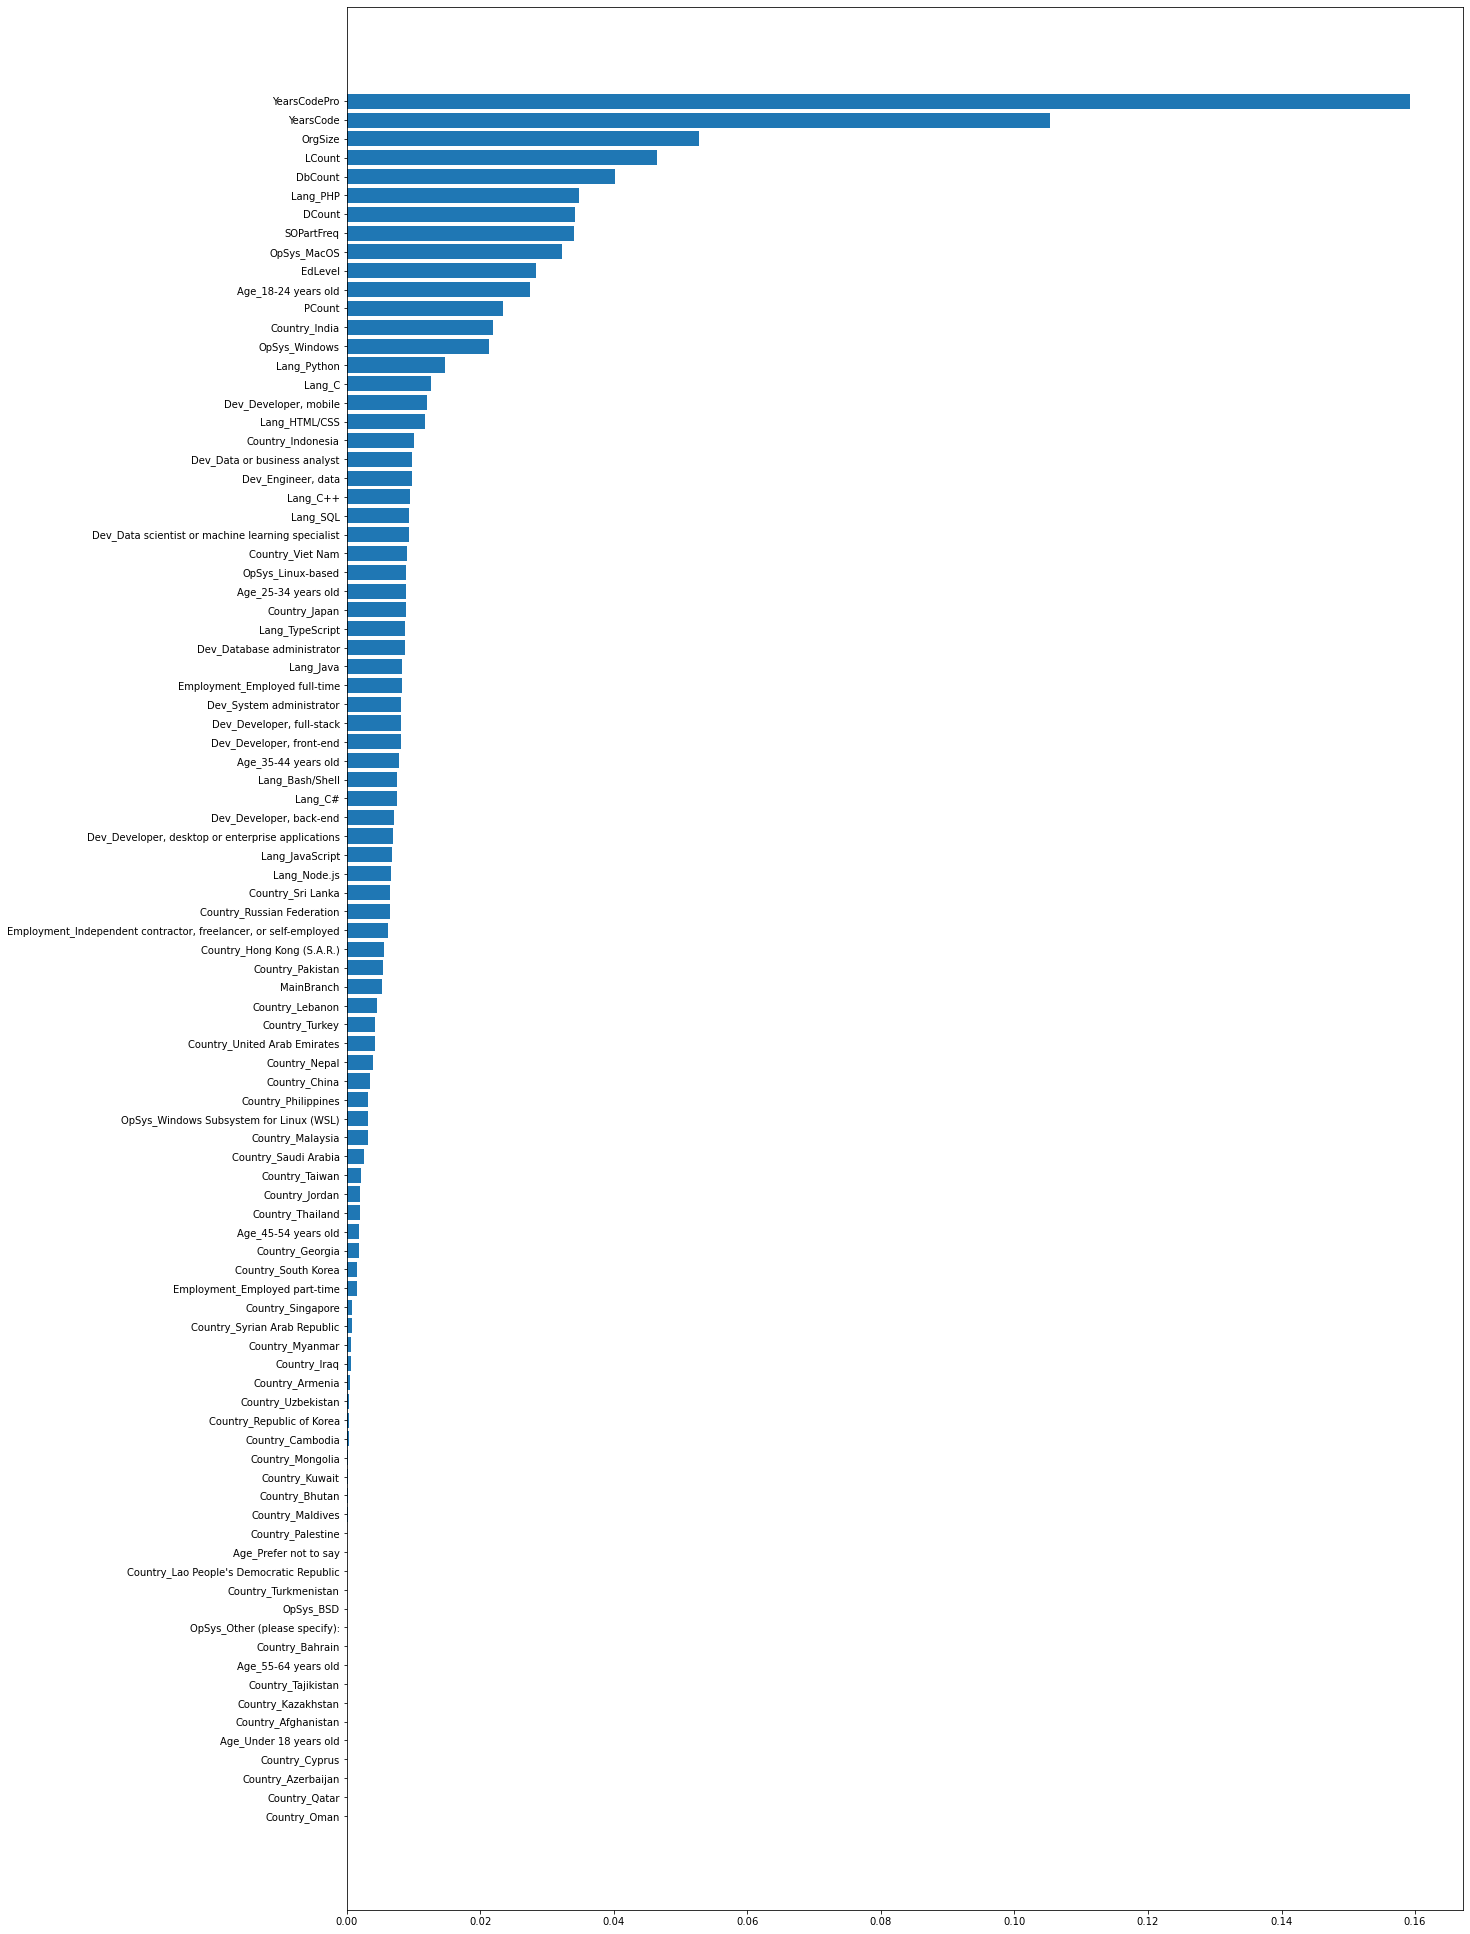

In [135]:
fig, ax = plt.subplots(figsize=(20,35))
plt.barh(X.columns[rf.feature_importances_.argsort()], rf.feature_importances_[rf.feature_importances_.argsort()])
# plt.autoscale()
plt.savefig('rf_feat_imp')